# Voice Inpainting Debug Demo

In [103]:
import os
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
import time
from loguru import logger

from src.tokenization import AudioTokenizer
from src.semantic_edit import SemanticEditor, EditOperation
from src.generation import TokenGenerator
from src.fusion import TokenFusion, FusionConfig, FusionMethod
from src.main import voice_inpainting, setup_device

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
# Input parameters
input_file = "data/input/28cbd5ea-3c84-434f-8f5e-f8410294cc92.wav"
edit_prompt = "Change 'chocolate' to 'cheesecake'"
output_file = "output.wav"
debug_dir = "data/debug_output"

# Create debug directory
os.makedirs(debug_dir, exist_ok=True)

In [177]:
# Display original audio
waveform, sample_rate = torchaudio.load(input_file)
print(f"Original Audio: {input_file}")
display(Audio(waveform, rate=sample_rate))

# Run voice inpainting
fused_tokens, final_audio, final_sr = voice_inpainting(
    edit_prompt=edit_prompt,
    input_file=input_file,
    output_file=output_file,
    fusion_method="contextual",
    debug=True,
    debug_dir=debug_dir,
    temperature=0.7,
    topk=30
)

Original Audio: data/input/28cbd5ea-3c84-434f-8f5e-f8410294cc92.wav


2025-03-22 19:27:44.892 | INFO     | src.main:voice_inpainting:65 - Debug mode enabled. Intermediate files will be saved to data/debug_output
2025-03-22 19:27:44.901 | INFO     | src.main:setup_device:35 - Using device: cuda
2025-03-22 19:27:44.901 | INFO     | src.main:voice_inpainting:74 - Tokenizing input audio to RVQ tokens...
2025-03-22 19:27:44.904 | INFO     | src.tokenization:_initialize_tokenizers:64 - Initializing Mimi RVQ tokenizer...
2025-03-22 19:27:47.140 | INFO     | src.tokenization:_initialize_tokenizers:70 - Initializing Llama text tokenizer...
2025-03-22 19:27:48.868 | INFO     | src.tokenization:_initialize_tokenizers:73 - Loading Whisper ASR model...
2025-03-22 19:27:50.289 | INFO     | src.tokenization:tokenize:109 - Tokenizing audio from data/input/28cbd5ea-3c84-434f-8f5e-f8410294cc92.wav
2025-03-22 19:27:50.296 | INFO     | src.tokenization:tokenize:118 - Resampling from 44100Hz to 24000Hz
2025-03-22 19:27:50.338 | INFO     | src.tokenization:tokenize:127 - Extr

ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 19098.41it/s]
2025-03-22 19:29:26.277 | INFO     | src.generation:_initialize_csm_model:58 - CSM model loaded successfully
2025-03-22 19:29:26.278 | INFO     | src.tokenization:_initialize_tokenizers:64 - Initializing Mimi RVQ tokenizer...
2025-03-22 19:29:26.778 | INFO     | src.tokenization:_initialize_tokenizers:70 - Initializing Llama text tokenizer...
2025-03-22 19:29:27.333 | INFO     | src.tokenization:_initialize_tokenizers:73 - Loading Whisper ASR model...
2025-03-22 19:29:28.411 | INFO     | src.generation:generate_replacement_tokens:173 - Generating replacement tokens for: 'cheesecake'
2025-03-22 19:29:28.412 | INFO     | src.tokenization:extract_context_audio:345 - Extracted context audio from -1.24s to 5.32s
2025-03-22 19:29:28.413 | INFO     | src.generation:_prepare_context_segment:115 - Prepared context: 'one piece of [...] please'
2025-03-22 19:29:28.415 | INFO     | src.generation:generate_replacement_tokens:180 

In [178]:
fusion_method = "crossfade"
debug = True
debug_dir  = "data/debug_output"
temperature = 0.7
topk = 30

start_time = time.time()

# Create debug directory if debug mode is enabled
if debug:
    logger.info(
        f"Debug mode enabled. Intermediate files will be saved to {debug_dir}"
    )
    os.makedirs(debug_dir, exist_ok=True)

# Set up device
device = setup_device()

# Step 1: Tokenize input audio to RVQ tokens
logger.info("Tokenizing input audio to RVQ tokens...")
tokenizer = AudioTokenizer(device=device)
tokenized_audio = tokenizer.tokenize(input_file)

if debug:
    # Save original audio for reference
    torchaudio.save(
        os.path.join(debug_dir, "01_original.wav"),
        tokenized_audio.audio.unsqueeze(0),
        tokenized_audio.sample_rate,
    )

    # Save tokenized representation info
    with open(os.path.join(debug_dir, "02_tokenization.txt"), "w") as f:
        f.write(f"RVQ Tokens shape: {tokenized_audio.rvq_tokens.shape}\n")
        f.write("Frame rate: 12.5 Hz (80ms per frame)\n")
        f.write(
            f"Duration: {tokenized_audio.rvq_tokens.shape[1] / 12.5:.2f} seconds\n"
        )
        f.write(f"Extracted text: {tokenized_audio.text}\n")
        f.write(f"Speaker ID: {tokenized_audio.speaker_id}\n\n")

        f.write("Word timestamps from Whisper:\n")
        if tokenized_audio.word_timestamps:
            for i, word in enumerate(tokenized_audio.word_timestamps):
                f.write(
                    f"{i}: '{word['word']}' ({word['start']:.2f}s - {word['end']:.2f}s)\n"
                )

# Step 2: Identify edit region in tokens
logger.info("Identifying edit region based on prompt...")
editor = SemanticEditor(tokenizer)
# edit_op = editor.find_edit_region(tokenized_audio, edit_prompt)

text = tokenized_audio.text

# Query LLM to find what to replace
subseq_original, subseq_edited = editor._find_edit_substring(text, edit_prompt)
logger.info(f"Edit proposal: '{subseq_original}' -> '{subseq_edited}'")

2025-03-22 19:29:32.326 | INFO     | __main__:<module>:11 - Debug mode enabled. Intermediate files will be saved to data/debug_output
2025-03-22 19:29:32.327 | INFO     | src.main:setup_device:35 - Using device: cuda
2025-03-22 19:29:32.328 | INFO     | __main__:<module>:20 - Tokenizing input audio to RVQ tokens...
2025-03-22 19:29:32.328 | INFO     | src.tokenization:_initialize_tokenizers:64 - Initializing Mimi RVQ tokenizer...
2025-03-22 19:29:33.099 | INFO     | src.tokenization:_initialize_tokenizers:70 - Initializing Llama text tokenizer...
2025-03-22 19:29:33.758 | INFO     | src.tokenization:_initialize_tokenizers:73 - Loading Whisper ASR model...
2025-03-22 19:29:34.664 | INFO     | src.tokenization:tokenize:109 - Tokenizing audio from data/input/28cbd5ea-3c84-434f-8f5e-f8410294cc92.wav
2025-03-22 19:29:34.685 | INFO     | src.tokenization:tokenize:118 - Resampling from 44100Hz to 24000Hz
2025-03-22 19:29:34.718 | INFO     | src.tokenization:tokenize:127 - Extracting RVQ token

In [179]:
# Find the token range for the edit
# First locate the text indices
try:
    start_char_idx = text.index(subseq_original)
    end_char_idx = start_char_idx + len(subseq_original)
except ValueError:
    logger.warning(
        f"Could not find '{subseq_original}' in text, using fuzzy matching"
    )
    start_char_idx, end_char_idx = editor._fuzzy_find_substring(
        text, subseq_original
    )

# Now map the character indices to token indices
# Use text_to_token_map from the tokenized audio
start_token_idx, end_token_idx = editor.tokenizer.find_token_range(
    tokenized_audio, (start_char_idx, end_char_idx)
)

edit_op = EditOperation(
    original_text=subseq_original,
    edited_text=subseq_edited,
    start_token_idx=start_token_idx,
    end_token_idx=end_token_idx,
)

# Calculate time range for the edit
token_frame_rate = 12.5  # frames per second
start_time_sec = edit_op.start_token_idx / token_frame_rate
end_time_sec = edit_op.end_token_idx / token_frame_rate

if debug:
    with open(os.path.join(debug_dir, "03_edit_region.txt"), "w") as f:
        f.write(f"Edit prompt: {edit_prompt}\n")
        f.write(f"Original text: '{edit_op.original_text}'\n")
        f.write(f"Edited text: '{edit_op.edited_text}'\n")
        f.write(
            f"Token range: {edit_op.start_token_idx} to {edit_op.end_token_idx}\n"
        )
        f.write(f"Time range: {start_time_sec:.2f}s to {end_time_sec:.2f}s\n")
        f.write(
            f"Edit length: {edit_op.end_token_idx - edit_op.start_token_idx} frames, {end_time_sec - start_time_sec:.2f} seconds\n"
        )

    # Extract and save just the portion to be edited
    with torch.inference_mode():
        edit_tokens = tokenized_audio.rvq_tokens[
            :, edit_op.start_token_idx : edit_op.end_token_idx
        ]
        if edit_tokens.shape[1] > 0:
            edit_audio, edit_sr = tokenizer.reconstruct_audio(edit_tokens)
            edit_path = os.path.join(debug_dir, "03b_original_edit_region.wav")
            torchaudio.save(edit_path, edit_audio.unsqueeze(0), edit_sr)


orig_seg_path = os.path.join(debug_dir, "03b_original_edit_region.wav")
if os.path.exists(orig_seg_path):
    orig_waveform, orig_sr = torchaudio.load(orig_seg_path)
    print("Original Segment:")
    display(Audio(orig_waveform, rate=orig_sr))


2025-03-22 19:30:27.399 | INFO     | src.tokenization:find_token_range:37 - Text range (14, 23) maps to token range [22, 29]
2025-03-22 19:30:27.405 | INFO     | src.tokenization:reconstruct_audio:262 - Reconstructing audio from RVQ tokens...


Original Segment:


In [180]:
# Step 3: Generate new tokens for the edit
logger.info("Generating new tokens for the edited segment...")
generator = TokenGenerator(device=device)

with torch.inference_mode():
    generated_tokens = generator.generate_replacement_tokens(
        tokenized_audio, edit_op, temperature=temperature, topk=topk
    )

if debug:
    # Reconstruct and save just the generated audio
    with torch.inference_mode():
        gen_audio, gen_sr = tokenizer.reconstruct_audio(generated_tokens)
        gen_path = os.path.join(debug_dir, "04_generated_segment.wav")
        torchaudio.save(gen_path, gen_audio.unsqueeze(0), gen_sr)

    with open(os.path.join(debug_dir, "04b_generation_info.txt"), "w") as f:
        f.write(f"Generated tokens shape: {generated_tokens.shape}\n")
        f.write(
            f"Generated duration: {generated_tokens.shape[1] / 12.5:.2f} seconds\n"
        )
        f.write("Generation parameters:\n")
        f.write(f"  Temperature: {temperature}\n")
        f.write(f"  Top-k: {topk}\n")

# Compare original and edited sections
gen_path = os.path.join(debug_dir, "04_generated_segment.wav")
if os.path.exists(gen_path):
    gen_waveform, gen_sr = torchaudio.load(gen_path)
    print("Generated Segment:")
    display(Audio(gen_waveform, rate=gen_sr))


2025-03-22 19:30:27.590 | INFO     | __main__:<module>:2 - Generating new tokens for the edited segment...
2025-03-22 19:30:27.591 | INFO     | src.generation:_initialize_csm_model:49 - Initializing CSM model...


ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 143112.73it/s]
2025-03-22 19:31:02.294 | INFO     | src.generation:_initialize_csm_model:58 - CSM model loaded successfully
2025-03-22 19:31:02.295 | INFO     | src.tokenization:_initialize_tokenizers:64 - Initializing Mimi RVQ tokenizer...
2025-03-22 19:31:02.794 | INFO     | src.tokenization:_initialize_tokenizers:70 - Initializing Llama text tokenizer...
2025-03-22 19:31:03.496 | INFO     | src.tokenization:_initialize_tokenizers:73 - Loading Whisper ASR model...
2025-03-22 19:31:04.990 | INFO     | src.generation:generate_replacement_tokens:173 - Generating replacement tokens for: 'cheesecake'
2025-03-22 19:31:04.991 | INFO     | src.tokenization:extract_context_audio:345 - Extracted context audio from -1.24s to 5.32s
2025-03-22 19:31:04.992 | INFO     | src.generation:_prepare_context_segment:115 - Prepared context: 'one piece of [...] please'
2025-03-22 19:31:04.994 | INFO     | src.generation:generate_replacement_tokens:180

Generated Segment:


In [ ]:
context_audio = tokenizer.extract_context_audio(
            tokenized_audio,
            (edit_op.start_token_idx, edit_op.end_token_idx),
            context_seconds,
        )

In [185]:
# fusion_method = "crossfade"
fusion_method = "contextual"

# Step 4: Fuse tokens
logger.info(f"Fusing tokens using {fusion_method} method...")
fusion_config = FusionConfig(
    method=FusionMethod(fusion_method),
    crossfade_frames=4,
    alpha=0.05,
    decay_factor=0.01,
    use_semantic_preservation=True,
)

fusion = TokenFusion(config=fusion_config)

with torch.inference_mode():
    fused_tokens = fusion.fuse_tokens(
        tokenized_audio.rvq_tokens,
        generated_tokens,
        (edit_op.start_token_idx, edit_op.end_token_idx),
    )

# Step 5: Reconstruct audio from fused tokens
logger.info("Reconstructing audio from fused tokens...")
with torch.inference_mode():
    final_audio, final_sr = tokenizer.reconstruct_audio(fused_tokens)

# Save the result
out_dir = os.path.dirname(output_file)
if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

logger.info(f"Saving final audio to {output_file}")
torchaudio.save(output_file, final_audio.unsqueeze(0), final_sr)

if debug:
    # Also save a debug copy
    debug_output = os.path.join(debug_dir, "05_final_result.wav")
    torchaudio.save(debug_output, final_audio.unsqueeze(0), final_sr)

    # Save fusion information
    with open(os.path.join(debug_dir, "06_fusion_info.txt"), "w") as f:
        f.write(f"Fusion method: {fusion_method}\n")
        f.write(f"Original tokens shape: {tokenized_audio.rvq_tokens.shape}\n")
        f.write(f"Generated tokens shape: {generated_tokens.shape}\n")
        f.write(f"Fused tokens shape: {fused_tokens.shape}\n")
        f.write(f"Final duration: {fused_tokens.shape[1] / 12.5:.2f} seconds\n")

elapsed_time = time.time() - start_time
logger.info(
    f"Voice inpainting completed successfully in {elapsed_time:.2f} seconds"
)

# Display edited audio
print(f"Edited Audio: {output_file}")
display(Audio(final_audio, rate=final_sr))

2025-03-22 19:34:41.263 | INFO     | __main__:<module>:5 - Fusing tokens using contextual method...
2025-03-22 19:34:41.289 | INFO     | src.fusion:fuse_tokens:121 - Fused tokens with method: contextual
2025-03-22 19:34:41.290 | INFO     | __main__:<module>:24 - Reconstructing audio from fused tokens...
2025-03-22 19:34:41.291 | INFO     | src.tokenization:reconstruct_audio:262 - Reconstructing audio from RVQ tokens...
2025-03-22 19:34:41.303 | INFO     | __main__:<module>:33 - Saving final audio to output.wav
2025-03-22 19:34:41.309 | INFO     | __main__:<module>:50 - Voice inpainting completed successfully in 308.98 seconds


Edited Audio: output.wav


In [184]:
# Show debug information
def print_debug_file(filename):
    path = os.path.join(debug_dir, filename)
    if os.path.exists(path):
        print(f"\n=== {filename} ===")
        with open(path, 'r') as f:
            print(f.read())

print_debug_file("02_tokenization.txt")
print_debug_file("03_edit_region.txt")
print_debug_file("04b_generation_info.txt")
print_debug_file("06_fusion_info.txt")


=== 02_tokenization.txt ===
RVQ Tokens shape: torch.Size([32, 43])
Frame rate: 12.5 Hz (80ms per frame)
Duration: 3.44 seconds
Extracted text:  one piece of chocolate please
Speaker ID: 0

Word timestamps from Whisper:
0: ' one' (0.00s - 0.96s)
1: ' piece' (0.96s - 1.38s)
2: ' of' (1.38s - 1.74s)
3: ' chocolate' (1.74s - 2.12s)
4: ' please' (2.12s - 2.56s)


=== 03_edit_region.txt ===
Edit prompt: Change 'chocolate' to 'cheesecake'
Original text: 'chocolate'
Edited text: 'cheesecake'
Token range: 22 to 29
Time range: 1.76s to 2.32s
Edit length: 7 frames, 0.56 seconds


=== 04b_generation_info.txt ===
Generated tokens shape: torch.Size([32, 9])
Generated duration: 0.72 seconds
Generation parameters:
  Temperature: 0.7
  Top-k: 30


=== 06_fusion_info.txt ===
Fusion method: crossfade
Original tokens shape: torch.Size([32, 43])
Generated tokens shape: torch.Size([32, 9])
Fused tokens shape: torch.Size([32, 45])
Final duration: 3.60 seconds



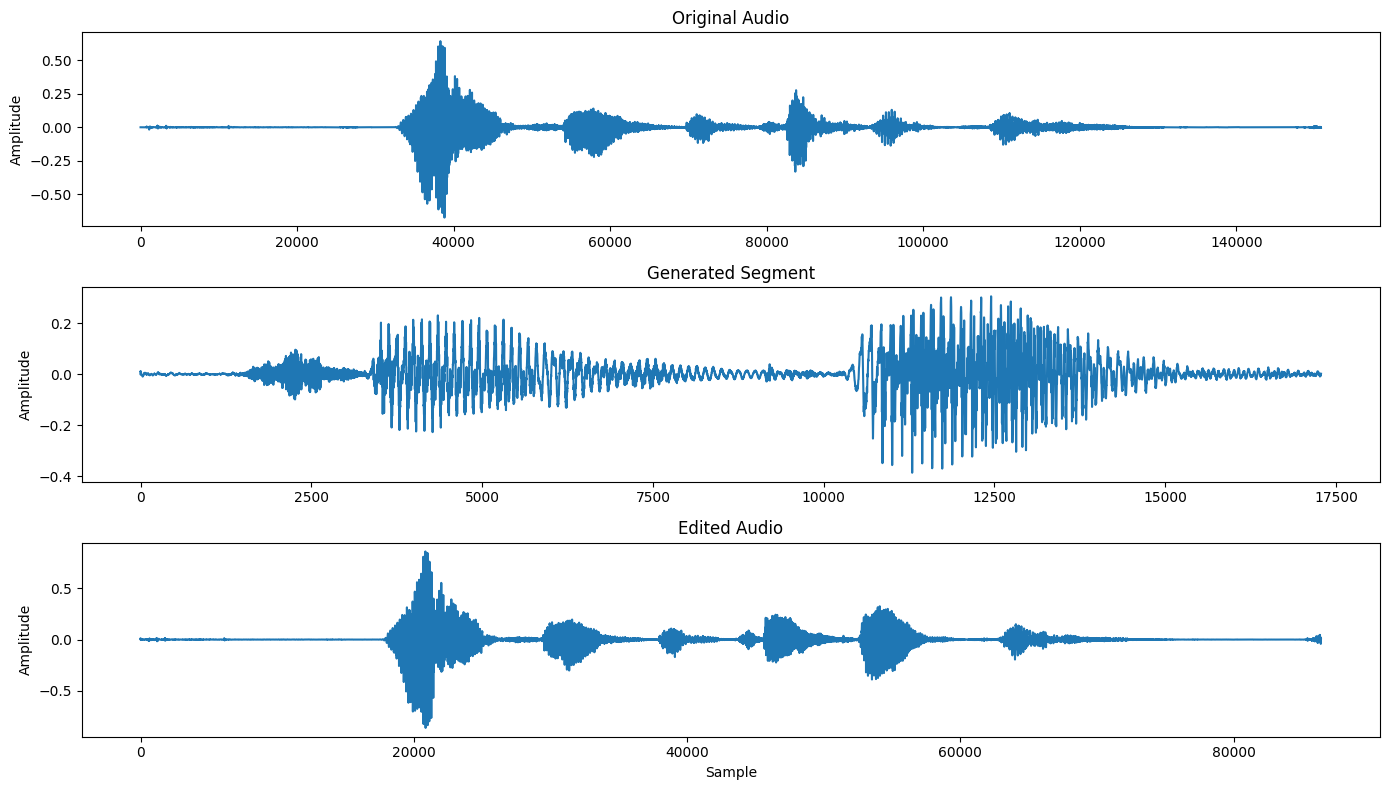

In [183]:
# Plot waveforms for comparison
plt.figure(figsize=(14, 8))

# Original audio
plt.subplot(3, 1, 1)
plt.plot(waveform[0].numpy())
plt.title("Original Audio")
plt.ylabel("Amplitude")

# Edited audio
plt.subplot(3, 1, 3)
plt.plot(final_audio.numpy())
plt.title("Edited Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

# Generated segment
if os.path.exists(gen_path):
    plt.subplot(3, 1, 2)
    plt.plot(gen_waveform[0].numpy())
    plt.title("Generated Segment")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()